In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import requests
from datetime import *
import math
import time

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
today = datetime.today() - timedelta(days=1) # since it takes some time to update actual currency data for today

def currency_val(currency, date):
    response = requests.get("https://www.xe.com/currencytables/?from={}&date={}#table-section".format(currency, date.strftime('%Y-%m-%d')))
    return pd.read_html(response.text)[0]

currency_list = currency_val("KRW", today)["Currency"][:166]
currency_list

0      USD
1      EUR
2      GBP
3      INR
4      AUD
      ... 
161    TMT
162    GGP
163    IMP
164    TVD
165    ZMW
Name: Currency, Length: 166, dtype: object

## Functions

### Simple Moving Average (SMA) calculation

In [3]:
def moving_average(df, days):
    return df.rolling(days).mean()

### Iterative web scraping for historic currency data

In [5]:
#currency: str(currency of interest)
#day: int(number of days ago) 
#currency_list = list(["currency 1", "currency 2" ...])

#Example: iter_currency("KRW", 200, ["USD", "EUR", "SGD", "JPY"]) 

def iter_currency(currency, day, currency_list): 
    from concurrent.futures import ThreadPoolExecutor
    
    start_time = time.time()
    
    today = datetime.today() - timedelta(days=1)
    currency_list = list(currency_list)
    rate_df = pd.DataFrame()
    
    
    def iter_url(url):
        response = requests.get(url)
        return pd.read_html(response.text)[0]
    
    
    for i in range(0, len(currency_list)):
        print("Processing %d of %d" %(i+1, len(currency_list)))
        rate_list = []
        date_list = []
        response_url = []
        for j in range(day, 0-1, -1):
            date = today - timedelta(days=j)
            date_list.append(date.strftime('%Y-%m-%d'))
            response_url.append("https://www.xe.com/currencytables/?from={}&date={}#table-section".format(currency, date.strftime('%Y-%m-%d')))
        
        with ThreadPoolExecutor(max_workers=400) as pool:
            response_list = list(pool.map(iter_url, response_url))
            
        for k in range(0, len(response_list)):
            df = response_list[k]
            rate_list.append(df.loc[df["Currency"] == list(currency_list)[i]]["%s per unit" %currency].values)
        rate_df[currency_list[i]] = pd.DataFrame(rate_list)
    rate_df.index = date_list
    
    
    global rate
    rate = rate_df
    
    print("----- %.2f s taken -----" % (time.time() - start_time))
    
    return rate # please call 'rate' separately to save the scraped data

In [123]:
def update_rate(currency, currency_list): 
    from concurrent.futures import ThreadPoolExecutor
    
    currency_list = list(currency_list)
    rate_df = pd.DataFrame()
    
    def iter_url(url):
        response = requests.get(url)
        return pd.read_html(response.text)[0]
    
    for i in range(0, len(currency_list)):
        response_url = []
        response_url.append("https://www.xe.com/currencytables/?from={}&date={}#table-section".format(currency, today.strftime('%Y-%m-%d')))
        
    with ThreadPoolExecutor(max_workers=200) as pool:
        response_list = list(pool.map(iter_url, response_url))
    
    df = response_list[0]
    rate_list = []
    
    for k in range(0, len(currency_list)):
        rate_list.append(df.loc[df["Currency"] == list(currency_list)[k]]["%s per unit" %currency].values)
    
    rate_df = pd.DataFrame(rate_list).astype(float).transpose()
    rate_df.columns = currency_list
    
    return rate_df

## SMA Example (KRW-USD)

### Simple Moving Average over past 200 days

In [5]:
# WARNING: running this cell may cause performance issue while running due to multithreading
# approximately takes 25s  

iter_currency("KRW", 200+200, ["USD"])

Processing 1 of 1
----- 23.91 s taken -----


,USD
2022-02-17,1198.042525
2022-02-18,1196.829844
2022-02-19,1196.077108
2022-02-20,1196.109484
2022-02-21,1192.349408
...,...
2023-03-20,1306.134444
2023-03-21,1306.343953
2023-03-22,1304.347582
2023-03-23,1278.967162


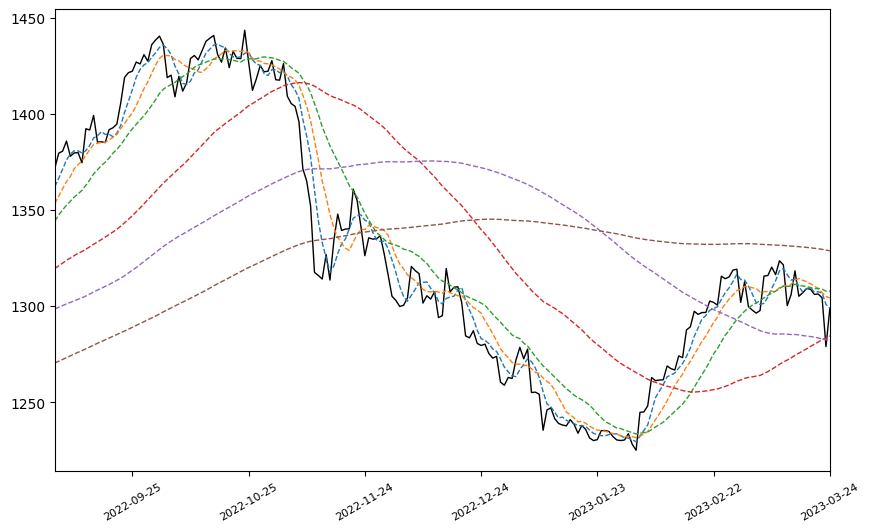

In [11]:
plt.figure(figsize =(10, 6))
plt.plot(rate.index[200:], rate["USD"][200:], label = "KRW per USD", linewidth = 1, color = 'black')
plt.plot(rate.index[200:], moving_average(rate["USD"], 5)[200:], '--', label = "SMA(5)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 10)[200:], '--', label ="SMA(10)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 20)[200:], '--', label ="SMA(20)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 60)[200:], '--', label ="SMA(60)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 120)[200:], '--', label ="MA(120)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 200)[200:], '--', label ="MA(200)", linewidth = 1)

plt.xticks(np.arange(len(rate.index[200:])-1, 0, -30), rotation = 30, fontsize = 8)
plt.margins(x=0, y=0.05)
plt.savefig("rate.png", bbox_inches='tight')

### Simple Moving Average over past 3 years

In [493]:
# WARNING: running this cell may cause performance issue while running due to multithreading
# approximately takes 80s 

iter_currency("KRW", 365*3+200, ["USD"])

Processing 1 of 1
----- 77.05 s taken -----


,USD
2019-08-03,1204.664602
2019-08-04,1204.538232
2019-08-05,1218.391678
2019-08-06,1213.616927
2019-08-07,1219.335956
...,...
2023-02-14,1273.250697
2023-02-15,1287.637352
2023-02-16,1289.227657
2023-02-17,1297.330283


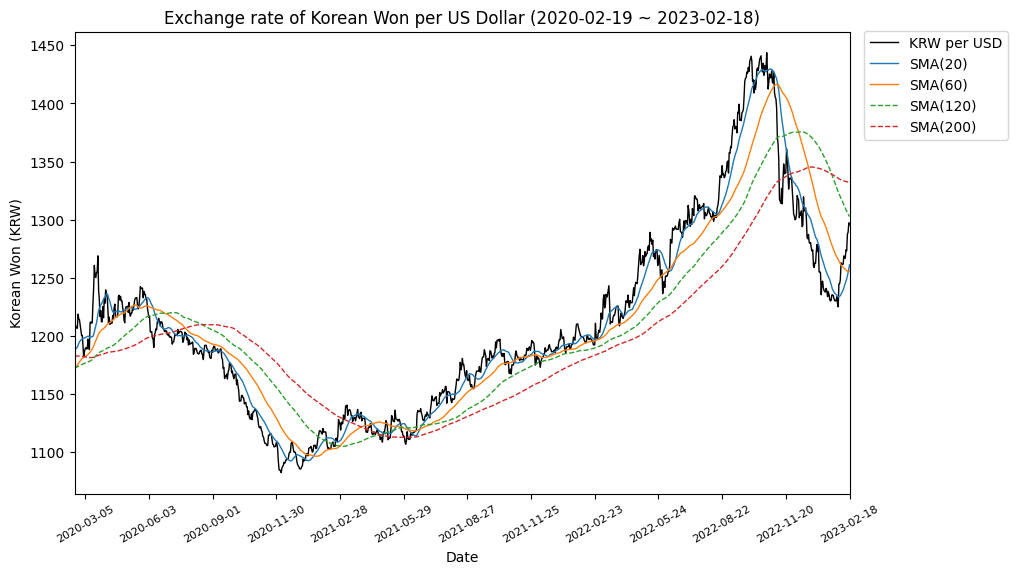

In [494]:
plt.figure(figsize =(10, 6))
plt.plot(rate.index[200:], rate["USD"][200:], label = "KRW per USD", linewidth = 1, color = 'black')
#plt.plot(rate.index[200:], moving_average(rate["USD"], 5)[200:].dropna(),label ="SMA(5)", linewidth = 1)
#plt.plot(rate.index[200:], moving_average(rate["USD"], 10)[200:].dropna(),label ="SMA(10)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 20)[200:].dropna(), label ="SMA(20)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 60)[200:].dropna(), label ="SMA(60)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 120)[200:].dropna(), '--', label ="SMA(120)", linewidth = 1)
plt.plot(rate.index[200:], moving_average(rate["USD"], 200)[200:].dropna(), '--', label ="SMA(200)", linewidth = 1)

plt.xticks(np.arange(len(rate.index[200:])-1, 0, -90), rotation = 30, fontsize = 8)
plt.xlabel("Date")
plt.ylabel("Korean Won (KRW)")
plt.title("Exchange rate of Korean Won per US Dollar (%s ~ %s)" % (rate.index[200], rate.index[-1]))
plt.legend(bbox_to_anchor=(1.01, 1.017))
plt.margins(x=0, y=0.05)

## Exploratory Analysis

In [6]:
# WARNING: running this cell may cause performance issue while running due to multithreading
# Run this cell to scrape historic currency data for KRW over past 200 days
# approximately takes 30 mins  

iter_currency("KRW", 200, currency_list)
KRW_data = rate

Processing 1 of 166
Processing 2 of 166
Processing 3 of 166
Processing 4 of 166
Processing 5 of 166
Processing 6 of 166
Processing 7 of 166
Processing 8 of 166
Processing 9 of 166
Processing 10 of 166
Processing 11 of 166
Processing 12 of 166
Processing 13 of 166
Processing 14 of 166
Processing 15 of 166
Processing 16 of 166
Processing 17 of 166
Processing 18 of 166
Processing 19 of 166
Processing 20 of 166
Processing 21 of 166
Processing 22 of 166
Processing 23 of 166
Processing 24 of 166
Processing 25 of 166
Processing 26 of 166
Processing 27 of 166
Processing 28 of 166
Processing 29 of 166
Processing 30 of 166
Processing 31 of 166
Processing 32 of 166
Processing 33 of 166
Processing 34 of 166
Processing 35 of 166
Processing 36 of 166
Processing 37 of 166
Processing 38 of 166
Processing 39 of 166
Processing 40 of 166
Processing 41 of 166
Processing 42 of 166
Processing 43 of 166
Processing 44 of 166
Processing 45 of 166
Processing 46 of 166
Processing 47 of 166
Processing 48 of 166
P

KeyboardInterrupt: 

In [ ]:
KRW_data.to_csv("KRW_data")

### Ranking by weighted moving average differential (KRW)

In [171]:
KRW_data = pd.read_csv("KRW_data.csv")
KRW_data.rename(columns = {KRW_data.columns[0] :  "Date"}, inplace = True)

KRW_data

,Date,USD,EUR,GBP,INR,AUD,CAD,SGD,CHF,MYR,...,FKP,SHP,SPL,WST,JEP,TMT,GGP,IMP,TVD,ZMW
0,2022-09-05,1371.924167,1362.500667,1580.344300,17.193442,933.274573,1044.402626,977.118884,1400.004610,306.642123,...,1580.344300,1580.344300,8231.545032,501.998954,1580.344300,391.580832,1580.344300,1580.344300,933.274573,89.085803
1,2022-09-06,1379.638742,1367.254505,1592.966665,17.275986,931.200944,1051.427481,981.114370,1401.670208,306.588993,...,1592.966665,1592.966665,8277.832484,505.229731,1592.966665,394.906263,1592.966665,1592.966665,931.200944,89.429011
2,2022-09-07,1380.681141,1372.313204,1583.579672,17.296673,929.172340,1048.685105,981.129904,1407.566107,306.783487,...,1583.579672,1583.579672,8284.086878,504.764122,1583.579672,395.209728,1583.579672,1583.579672,929.172340,89.145014
3,2022-09-08,1385.942962,1379.999955,1591.826758,17.387288,934.173200,1056.624025,985.447248,1425.089677,307.931249,...,1591.826758,1591.826758,8315.657807,506.311970,1591.826758,396.904485,1591.826758,1591.826758,934.173200,89.544651
4,2022-09-09,1378.053035,1384.253262,1598.053669,17.309563,943.079957,1056.891997,985.127196,1434.330552,304.096536,...,1598.053669,1598.053669,8268.318244,502.304993,1598.053669,400.279956,1598.053669,1598.053669,943.079957,88.064777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2023-03-20,1306.134444,1400.282682,1600.795235,15.816896,876.528264,954.320004,975.666692,1408.960759,291.160911,...,1600.795235,1600.795235,7836.806693,481.421915,1600.795235,373.867249,1600.795235,1600.795235,876.528264,63.155377
197,2023-03-21,1306.343953,1406.973773,1593.084268,15.797203,868.920489,951.321891,976.050086,1414.275019,292.038126,...,1593.084268,1593.084268,7838.063752,480.883431,1593.084268,373.928720,1593.084268,1593.084268,868.920489,62.721253
198,2023-03-22,1304.347582,1407.478030,1595.188288,15.792128,871.942084,950.444100,978.326791,1412.159096,292.734369,...,1595.188288,1595.188288,7826.085523,480.330590,1595.188288,373.359167,1595.188288,1595.188288,871.942084,62.378863
199,2023-03-23,1278.967162,1392.808072,1575.926703,15.580112,859.340708,936.468380,965.545625,1398.321005,289.479049,...,1575.926703,1575.926703,7673.803003,471.479844,1575.926703,366.098612,1575.926703,1575.926703,859.340708,60.707248


In [172]:
data = KRW_data
weighted_ma = pd.DataFrame([])


ma_list = [5, 20, 60, 120, 200] 
weight_list = [0.2, 0.1333, 0.3333, 0.2, 0.1334]


for i in range(0, len(currency_list)):
    currency_ma = []
    for j in range(0,len(ma_list)):
        currency_ma.append(moving_average(data.iloc[0:,i+1], ma_list[j]).tail(1).values)
    weighted_ma[data.iloc[0:,i+1].name] = pd.DataFrame(currency_ma)
    
    
weighted_ma = weighted_ma.apply(lambda x: (np.asarray(x) * np.asarray(weight_list)).sum())

forex_score = ((weighted_ma - data.drop("Date", axis = 1).iloc[-1]) / weighted_ma * 100).sort_values(ascending = False)
forex_score = pd.DataFrame(forex_score).reset_index()
forex_score.columns = ["Currency abbreviation", "Forex score"]

forex_score.dropna(inplace = True)

forex_score

# positive values mean high value, negative values mean low value compared to weighted moving average

,Currency abbreviation,Forex score
0,LBP,71.311400
1,VEF,16.872521
2,VES,16.872521
3,XPD,8.520952
4,ZMW,7.424670
...,...,...
160,CRC,-3.655220
161,MRU,-4.052806
162,XAG,-5.011908
163,XAU,-5.803911


In [182]:
currency_code = pd.read_csv("currency_code.csv")

currency_code = currency_code.merge(forex_score, how = "inner")

currency_code["PPP"] =  currency_code["GDP per capita"] / currency_code["GDP per capita PPP"]
currency_code["Final score"] = (1/currency_code["PPP"])*0.2+ (np.log(currency_code["Forex score"] + abs(min(currency_code["Forex score"])) + 1))*0.8

currency_code.sort_values(by = ["Final score"], ascending = False).head()

,Country,Currency,Currency abbreviation,GDP per capita PPP,GDP per capita,Forex score,PPP,Final score
134,Lebanon,Lebanese Pound,LBP,14256.689710,4136.10,71.311400,0.290116,4.195602
185,Syrian Arab Republic,Syrian Pound,SYP,4684.720000,726.74,-0.212759,0.155130,3.004688
159,Pakistan,Pakistan Rupee,PKR,5748.005952,1505.00,6.632171,0.261830,2.950364
182,Sudan,Sudanese Pound,SDG,4065.976074,751.80,1.007568,0.184900,2.904007
206,Zambia,Kwacha,ZMW,3555.920229,1137.30,7.424670,0.319833,2.852028
